In [1]:
import matplotlib.pyplot as plt

import pyBeamSim
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.optim as optim
from model.model_with_attention import Encoder_Decoder

from torchsummary import summary

from deap import base, creator, tools, algorithms


model参数加载 应该使用 src 没有标准化， tgt标准化 训练的model

In [2]:
df = pd.read_csv('../data/data_10000.csv', index_col=0)

input_size = 1
output_size = 1
use_models = ['GRU', 'LSTM']

batch_size = 64
hidden_size = 64
num_layers = 2
dropout = 0
weight_decay = 0
teacher_forcing = 0.5

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
use_model = use_models[0]

model = Encoder_Decoder(input_size=input_size,
                        encoder_hidden_size=hidden_size,
                        decoder_hidden_size=hidden_size,
                        output_size=output_size,
                        model_device=device,
                        num_layers=num_layers,
                        teacher_forcing=teacher_forcing,
                        dropout=dropout)

# load model (z-score)
model.load_state_dict(torch.load('../model_save/seq2seq_2layers.pth'))

<All keys matched successfully>

In [3]:
"""" variable dataframe created"""
vary = ['drift1_len', 'quad1_len', 'quad1_gra', 'drift2_len', 'quad2_len', 'quad2_gra']
low = [0.1, 0.1, -20.0, 0.1, 0.1, -20.0]
high = [0.5, 0.5, 20.0, 0.5, 0.5, 20.0]
units = ['m', 'm', 'T/m', 'm', 'm', 'T/m']
variable = pd.DataFrame(index=vary)
variable['low'] = low
variable['high'] = high
variable['units'] = units
variable

,low,high,units
drift1_len,0.1,0.5,m
quad1_len,0.1,0.5,m
quad1_gra,-20.0,20.0,T/m
drift2_len,0.1,0.5,m
quad2_len,0.1,0.5,m
quad2_gra,-20.0,20.0,T/m


In [4]:
ref_energy = 5
num_particle = 102400
simulator = pyBeamSim.BeamSimulator()
simulator.init_beam(num_particle, 938.272046, 1.0, 0.0)
# key step
simulator.init_Beamline()
simulator.init_spacecharge()
simulator.set_beamTwiss(0, 0.003, 0.0001, 0, 0.003, 0.0001, 0, 8, 3.1415926e-11, 0, ref_energy, 500, 1)
simulator.UpdateBeamParameters()
simulator.save_initial_beam()

def simulate_by_seq(simulator, value_list):
    simulator.init_Beamline()
    simulator.restore_initial_beam()
    simulator.add_Drift('drift1', value_list[0], Aperture=0.05)
    simulator.add_Quad('quad1', value_list[1], Aperture=0.012, FieldGradient=value_list[2])
    simulator.add_Drift('drift2', value_list[3], Aperture=0.05)
    simulator.add_Quad('quad2', value_list[4], Aperture=0.028, FieldGradient=value_list[5])
    envelope = simulator.simulate_and_getEnvelope(use_spacecharge=True)
    simulator.UpdateBeamParameters()
    
    x_avg = envelope['Avg_x']
    x_avg1 = x_avg[1]
    x_avg4 = x_avg[4]
    return x_avg1, x_avg4

In [5]:
model.to('cpu')
model.eval()

def create_individual():
    return [np.random.uniform(row['low'], row['high']) for _, row in variable.iterrows()]

def evaluate(individual):
    # todo
    output = model(torch.tensor(individual).reshape(1, -1, 1), torch.Tensor([-2.582750e-09, 0, 0, 0, 0]).reshape(1, -1, 1)).detach()
    output = output.squeeze().numpy().tolist()
    return output[0], output[3]   # x_avg1 and x_avg4

def genInd(low, high):
    return [random.uniform(low_i, high_i) for low_i, high_i in zip(low, high)]

In [6]:
# define question
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))   # two min
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
low = [0.1, 0.1, -20.0, 0.1, 0.1, -20.0]
high = [0.5, 0.5, 20.0, 0.5, 0.5, 20.0]
n_genes = len(low)  # 6

# initial individual and population
toolbox.register('genInd',genInd,low,high)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.genInd)   # list
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=low, up=high, eta=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=low, up=high, eta=20.0, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

In [7]:
N_POP = 200#种群内个体数量
ngen = 100#迭代步数，参数过小，在收敛之前就结束搜索
cxpb = 0.8#交叉概率，参数过小，族群不能有效更新
mutpb = 0.2#突变概率，参数过小，容易陷入局部最优
hof = tools.ParetoFront()

population = toolbox.population(n=N_POP)
for ind in population:
    ind.fitness.values = toolbox.evaluate(ind)
for gen in range(1, ngen + 1):

    # 选择下一代的父母
    offspring = toolbox.select(population, len(population))

    # 克隆选择出来的个体
    offspring = list(map(toolbox.clone, offspring))

    # 应用交叉和变异
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # 重新评估所有失效的个体
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        ind.fitness.values = toolbox.evaluate(ind)

    # 将当前种群和后代种群合并
    population[:] = toolbox.select(population + offspring, len(population))

    # 更新 Pareto 前沿
    hof.update(population)

    # 输出当前代的最优解
    front = tools.sortNondominated(population, len(population), first_front_only=True) # one tuple  with a list if True
    print(f"num in Generation {gen}: {len(front[0])}")

num in Generation 1: 12
num in Generation 2: 11
num in Generation 3: 16
num in Generation 4: 18
num in Generation 5: 27
num in Generation 6: 16
num in Generation 7: 21
num in Generation 8: 33
num in Generation 9: 56
num in Generation 10: 37
num in Generation 11: 42
num in Generation 12: 35
num in Generation 13: 57
num in Generation 14: 98
num in Generation 15: 66
num in Generation 16: 29
num in Generation 17: 34
num in Generation 18: 54
num in Generation 19: 37
num in Generation 20: 36
num in Generation 21: 35
num in Generation 22: 36
num in Generation 23: 51
num in Generation 24: 33
num in Generation 25: 56
num in Generation 26: 56
num in Generation 27: 77
num in Generation 28: 84
num in Generation 29: 112
num in Generation 30: 180
num in Generation 31: 109
num in Generation 32: 129
num in Generation 33: 200
num in Generation 34: 194
num in Generation 35: 160
num in Generation 36: 170
num in Generation 37: 200
num in Generation 38: 200
num in Generation 39: 200
num in Generation 40: 2

In [13]:
dots = [] # for seq2seq
# true for simulator
true_x_avg1 = []
true_x_avg4 = []
for inv in front[0]:
    dots.append(inv.fitness.values)
    x_avg1, x_avg4 = simulate_by_seq(simulator, inv)
    true_x_avg1.append(x_avg1)
    true_x_avg4.append(x_avg4)
all_x_avg1 = [point[0] * 1.055991623224124e-05 + 3.188122255538191e-05 for point in dots]
all_x_avg4 = [point[1] * 0.00014960896561322487 + -4.8478108046593833e-05 for point in dots]

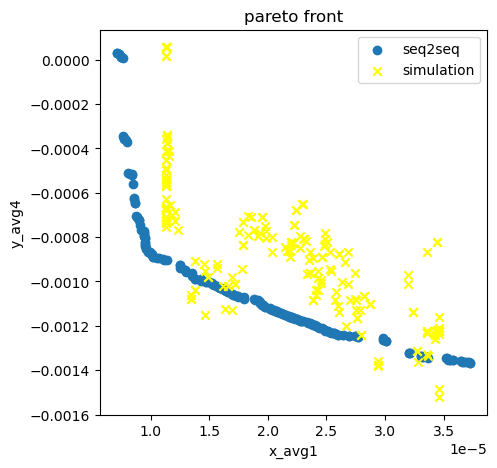

In [16]:
plt.figure(figsize=(5, 5))
plt.title('pareto front')
plt.xlabel('x_avg1')
plt.ylabel("y_avg4")

plt.scatter(all_x_avg1, all_x_avg4, label='seq2seq')
plt.scatter(true_x_avg1, true_x_avg4, color='yellow', marker='x', label='simulation')
plt.legend()